In [1]:
import pandas as pd
import numpy as np
import sys
import os
os.chdir('/Users/veronica/Documents/GitHub/analysis-tools')
from src import utils, credentials

In [2]:
creds = credentials.creds
engine = utils.create_sql_db(creds)

In [3]:
query = """WITH base as (
SELECT 
  c.contract_id,
  c.store_id,
  c.seller_name,
  c.plan_id,
  c.plan_purchase_price,
  pcrs_contracts.retail_cost_of_plan,
  pcrs_contracts.product_purchase_price,
  c.product_list_price,
  c.plan_sku,
  prod.reimbursement_amount,
  CASE WHEN prod.reimbursement_amount IS NOT NULL THEN prod.reimbursement_amount/100.0 ELSE c.product_list_price END as price_final,
  m.merchant_cut,
  p.retail_target,
  p.fixed_price,
  p.price_high,
  p.price_low
FROM analytics.contract_facts c
LEFT JOIN analytics.merchant_facts m -- get merchant_cut
ON c.store_id = m.store_id
LEFT JOIN analytics.product_facts prod -- get reimbursement amount
ON c.product_id = prod.product_id AND c.store_id = prod.store_id
LEFT JOIN analytics_pcrs.pcrs_contracts_sold AS pcrs_contracts
ON c.admin_contract_id = pcrs_contracts.contract_number
LEFT JOIN analytics.plans_pricing p
ON c.plan_id = p.plan_id
WHERE c.product_list_price BETWEEN (p.price_low/100.0) and (p.price_high/100.0) 
AND c.status in ('expired', 'live')
)

SELECT
  b.*,
  pm.cost/100.0 as cost
FROM base b
LEFT JOIN analytics.plans_matching pm -- get cost (premium) based on price_final (reimbursement_amount/product_list_price)
ON b.plan_id = pm.plan_id AND b.plan_sku = pm.vendor_sku AND b.price_high = pm.price_high and b.price_low = pm.price_low
WHERE 
b.price_final BETWEEN (b.price_low/100.0) AND (b.price_high/100.0)"""

df = pd.read_sql_query(query, engine)

In [11]:
# Clean Data
# Remove contracts with a fixed price, empty cost value, or where cost is set to 1

In [32]:
df_clean = df[(df['cost'].notnull()) & (df['cost']!= 0.01) & (df['fixed_price'].isnull())]
df_clean

,contract_id,store_id,seller_name,plan_id,plan_purchase_price,retail_cost_of_plan,product_purchase_price,product_list_price,plan_sku,reimbursement_amount,price_final,merchant_cut,retail_target,fixed_price,price_high,price_low,cost
0,6d968755-399d-406d-820e-ca5e60264bef,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.00,200.00,EXTRPLBG144,20000.0,200.00,0.50,0.15,NaN,20999,20000,11.68
1,0fbda1e9-92a2-47cb-b569-e9dd7294345a,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.00,200.00,EXTRPLBG144,20000.0,200.00,0.50,0.15,NaN,20999,20000,11.68
2,d5eda16b-b725-47cf-b76c-38a50effe209,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-1y,18.99,18.99,200.00,200.00,EXTRPLBG026,20000.0,200.00,0.50,0.09,NaN,20999,20000,6.02
3,db117591-2ac9-45d2-96ce-aa8d7b1c342a,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.00,200.00,EXTRPLBG144,20000.0,200.00,0.50,0.15,NaN,20999,20000,11.68
4,5cf54c74-cb80-491c-9ca0-f5dc55333580,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-1y,18.99,18.99,200.00,200.00,EXTRPLBG026,20000.0,200.00,0.50,0.09,NaN,20999,20000,6.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320981,e44c4806-dc50-4cfa-b751-af4a93d5cde4,fa26d28a-8ee7-40bb-b518-16351e1fbff3,Renogy,10001-misc-elec-base-replace-1y,2.79,2.79,23.99,23.99,EXTRPL1,2399.0,23.99,0.45,0.10,NaN,2499,0,1.23
320982,b0e569c2-5ed6-40de-bdab-e0f2461b4673,fa26d28a-8ee7-40bb-b518-16351e1fbff3,Renogy,10001-misc-elec-base-replace-1y,2.79,2.79,12.99,12.99,EXTRPL1,1299.0,12.99,0.45,0.10,NaN,2499,0,1.23
320983,b414af95-1902-4985-a61e-b8259b4915d3,fa26d28a-8ee7-40bb-b518-16351e1fbff3,Renogy,10001-misc-elec-base-replace-1y,2.79,2.79,12.99,12.99,EXTRPL1,1299.0,12.99,0.45,0.10,NaN,2499,0,1.23
320984,b7643305-badf-47f7-9b2d-10b5ab72b26a,780a27f2-578d-4455-818f-77b48453ffb9,Revel Boards,10001-misc-elec-base-replace-3y,209.00,209.00,769.00,769.00,EXTRPL51,NaN,769.00,0.20,0.26,NaN,99999,75000,112.66


In [5]:
def calc_target_price(df):
    df['target_price'] = df['retail_target'] * df['product_list_price']
    return df

In [6]:
def calc_min_price(df, extend_cut):
    df[f'min_price_{extend_cut}'] = df['cost'] / (1 - df['merchant_cut'] - extend_cut)
    return df

In [7]:
def calc_diff(df, min_price_col):
    df['price_diff'] = df['target_price'] - df[min_price_col]
    df['price_diff_pct'] = (df['target_price'] - df[min_price_col])/ df[min_price_col]
    return df

In [8]:
def find_price_floor(df, min_price_col):
    df['price_floor'] = np.where(df[min_price_col] > df['target_price'], 1, 0)
    return df

In [33]:
df_price = calc_target_price(df_clean)
df_price = calc_min_price(df_price, 0.10)
df_price = calc_diff(df_price, 'min_price_0.1')
df_price = find_price_floor(df_price, 'min_price_0.1')
df_price.head()

/Users/veronica/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/veronica/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,contract_id,store_id,seller_name,plan_id,plan_purchase_price,retail_cost_of_plan,product_purchase_price,product_list_price,plan_sku,reimbursement_amount,...,retail_target,fixed_price,price_high,price_low,cost,target_price,min_price_0.1,price_diff,price_diff_pct,price_floor
0,6d968755-399d-406d-820e-ca5e60264bef,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.0,200.0,EXTRPLBG144,20000.0,...,0.15,NaN,20999,20000,11.68,30.0,29.20,0.80,0.027397,0
1,0fbda1e9-92a2-47cb-b569-e9dd7294345a,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.0,200.0,EXTRPLBG144,20000.0,...,0.15,NaN,20999,20000,11.68,30.0,29.20,0.80,0.027397,0
2,d5eda16b-b725-47cf-b76c-38a50effe209,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-1y,18.99,18.99,200.0,200.0,EXTRPLBG026,20000.0,...,0.09,NaN,20999,20000,6.02,18.0,15.05,2.95,0.196013,0
3,db117591-2ac9-45d2-96ce-aa8d7b1c342a,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,30.99,30.99,200.0,200.0,EXTRPLBG144,20000.0,...,0.15,NaN,20999,20000,11.68,30.0,29.20,0.80,0.027397,0
4,5cf54c74-cb80-491c-9ca0-f5dc55333580,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-1y,18.99,18.99,200.0,200.0,EXTRPLBG026,20000.0,...,0.09,NaN,20999,20000,6.02,18.0,15.05,2.95,0.196013,0


In [34]:
len(df_price)

183189

In [35]:
df_pf = df_price[df_price['price_floor']==1]

In [36]:
len(df_pf)

67043

In [37]:
len(df_pf['store_id'].unique())

160

In [38]:
df_pf['seller_name'].value_counts().head(20)

BlendJet                  16284
JBL-US                    10150
RealTruck                  5601
L'ange Hair                5023
Carandtruckremotes.com     3836
Jewlr                      2195
EightVape                  1744
Skullcandy                 1725
DailySale                  1538
Parts Dr                   1306
RaceDayQuads               1253
Jetson Electric Bikes      1079
Logitech                   1024
Jegs High Performance       990
Motosport                   860
UE Custom                   716
Wyze Ecommerce              662
Blackstone Products         622
PCLiquidations              618
AutoAnything                605
Name: seller_name, dtype: int64

In [97]:
df_pf['retail_min_diff'] = abs(df_pf['retail_cost_of_plan'] - df_pf['min_price_0.1'])
df_pf['min_price_int'] = np.ceil(df_pf['min_price_0.1'])
df_pf['retail_min_int_diff'] = abs(df_pf['retail_cost_of_plan'] - df_pf['min_price_int'])
df_pf['retail_target_diff'] = abs(df_pf['retail_cost_of_plan'] - df_pf['target_price'])
df_pf['min_target_diff'] = abs(df_pf['min_price_0.1'] - df_pf['target_price'])
df_pf['min_target'] = df_pf['min_price_0.1']/df_pf['product_list_price']
df_pf['target_diff'] = df_pf['min_target'] - df_pf['retail_target']

/Users/veronica/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/veronica/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/veronica/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [98]:
df_pf[df_pf['product_purchase_price']==1]

,contract_id,store_id,seller_name,plan_id,plan_purchase_price,retail_cost_of_plan,product_purchase_price,product_list_price,plan_sku,reimbursement_amount,...,price_diff,price_diff_pct,price_floor,retail_min_diff,min_price_int,retail_min_int_diff,retail_target_diff,min_target_diff,min_target,target_diff
116251,37513773-3d63-4f23-b379-e0bdb03b6336,a92122f0-2e8b-47b8-9f29-9efbe3b327bb,Jewlr,A0-AAJEW-2y,23.99,5.49,1.0,1.0,EXTJEW1,100.0,...,-5.040210,-0.967372,1,0.279790,6.0,0.51,5.32,5.040210,5.210210,5.040210
125826,ea282390-c3a5-436d-9284-5d4b754cee91,a92122f0-2e8b-47b8-9f29-9efbe3b327bb,Jewlr,A1-AAJEW-2y,23.99,5.49,1.0,1.0,EXTJEW1,100.0,...,-4.950210,-0.950098,1,0.279790,6.0,0.51,5.23,4.950210,5.210210,4.950210
125827,7cfd276d-a55f-4c3c-b25d-86b6b25cca83,a92122f0-2e8b-47b8-9f29-9efbe3b327bb,Jewlr,A0-AAJEW-5y,54.99,12.99,1.0,1.0,EXTJEW35,100.0,...,-12.282913,-0.951212,1,0.077087,13.0,0.01,12.36,12.282913,12.912913,12.282913
125828,efe2ca21-4dea-483b-b4a6-d7704099e90e,a92122f0-2e8b-47b8-9f29-9efbe3b327bb,Jewlr,A1-AAJEW-2y,20.99,5.49,1.0,1.0,EXTJEW1,100.0,...,-4.950210,-0.950098,1,0.279790,6.0,0.51,5.23,4.950210,5.210210,4.950210
125829,68447e27-3352-4d7c-a3a7-96840207c0cb,a92122f0-2e8b-47b8-9f29-9efbe3b327bb,Jewlr,A1-AAJEW-2y,32.99,32.99,1.0,1.0,EXTJEW1,100.0,...,-4.950210,-0.950098,1,27.779790,6.0,26.99,32.73,4.950210,5.210210,4.950210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320487,88c53672-d1af-4045-add7-ec11bf3c92da,4939fa74-dfef-44ef-a548-67545b390ff8,Lee Fiori,A0-AAJEW-3y,39.99,8.49,1.0,1.0,EXTJEW18,100.0,...,-7.913333,-0.949600,1,0.156667,9.0,0.51,8.07,7.913333,8.333333,7.913333
320489,57808ca4-1dd5-476e-b355-43d487df1331,4939fa74-dfef-44ef-a548-67545b390ff8,Lee Fiori,A1-AAJEW-2y,17.99,5.49,1.0,1.0,EXTJEW1,100.0,...,-4.950210,-0.950098,1,0.279790,6.0,0.51,5.23,4.950210,5.210210,4.950210
320490,84239a00-9e4f-4f64-b791-96f4bcc9b362,4939fa74-dfef-44ef-a548-67545b390ff8,Lee Fiori,A1-AAJEW-2y,23.99,5.49,1.0,1.0,EXTJEW1,100.0,...,-4.950210,-0.950098,1,0.279790,6.0,0.51,5.23,4.950210,5.210210,4.950210
320491,3af1e5d6-363f-4a09-a80c-59273d0ccc32,4939fa74-dfef-44ef-a548-67545b390ff8,Lee Fiori,A0-AAJEW-5y,35.99,12.99,1.0,1.0,EXTJEW35,100.0,...,-12.282913,-0.951212,1,0.077087,13.0,0.01,12.36,12.282913,12.912913,12.282913


In [99]:
df_pf_clean = df_pf[df_pf['product_purchase_price']!=1]
df_pf_clean

,contract_id,store_id,seller_name,plan_id,plan_purchase_price,retail_cost_of_plan,product_purchase_price,product_list_price,plan_sku,reimbursement_amount,...,price_diff,price_diff_pct,price_floor,retail_min_diff,min_price_int,retail_min_int_diff,retail_target_diff,min_target_diff,min_target,target_diff
8,98a156f9-6cfa-464a-9d6c-5ab5a2e8bdd1,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-3y,43.99,43.99,200.00,200.00,EXTRPLBG262,20000.0,...,-3.650000,-0.083620,1,0.340000,44.0,0.01,3.9900,3.650000,0.218250,0.018250
35,38584aba-10a9-4842-8d5c-df36aa14665b,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,24.99,24.99,160.00,160.00,EXTRPLBG140,16000.0,...,-0.450000,-0.018405,1,0.540000,25.0,0.01,0.9900,0.450000,0.152812,0.002812
38,dea96777-485c-4b79-a7b6-831eb6a294e8,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,24.99,24.99,160.00,160.00,EXTRPLBG140,16000.0,...,-0.450000,-0.018405,1,0.540000,25.0,0.01,0.9900,0.450000,0.152812,0.002812
39,9daa6a3a-0a10-4de7-83ac-ba57f2cd4d7c,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-2y,24.99,24.99,160.00,160.00,EXTRPLBG140,16000.0,...,-0.450000,-0.018405,1,0.540000,25.0,0.01,0.9900,0.450000,0.152812,0.002812
54,ae1e8ccd-2d67-499d-b817-bcf95c6b9837,0233ca5d-1b3f-4983-8b37-e3c503572f5a,T3,B0-HBGEN-3y,54.99,54.99,235.00,235.00,EXTRPLBG265,23500.0,...,-3.025000,-0.060470,1,4.965000,51.0,3.99,7.9900,3.025000,0.212872,0.012872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320979,8999e57f-5c21-47fb-9833-71747bcecc44,61b0f110-9981-455e-bc39-37091635ad6a,Skullcandy,A1-ELPAU-1y,29.99,29.99,199.99,199.99,EXTPORAUD19,19999.0,...,-3.321300,-0.113278,1,0.670000,30.0,0.01,3.9913,3.321300,0.146607,0.016607
320980,af59de16-be40-4337-8a34-dcd519a68790,61b0f110-9981-455e-bc39-37091635ad6a,Skullcandy,A1-ELPAU-1y,29.99,29.99,199.99,199.99,EXTPORAUD19,19999.0,...,-3.321300,-0.113278,1,0.670000,30.0,0.01,3.9913,3.321300,0.146607,0.016607
320981,e44c4806-dc50-4cfa-b751-af4a93d5cde4,fa26d28a-8ee7-40bb-b518-16351e1fbff3,Renogy,10001-misc-elec-base-replace-1y,2.79,2.79,23.99,23.99,EXTRPL1,2399.0,...,-0.334333,-0.122317,1,0.056667,3.0,0.21,0.3910,0.334333,0.113936,0.013936
320982,b0e569c2-5ed6-40de-bdab-e0f2461b4673,fa26d28a-8ee7-40bb-b518-16351e1fbff3,Renogy,10001-misc-elec-base-replace-1y,2.79,2.79,12.99,12.99,EXTRPL1,1299.0,...,-1.434333,-0.524756,1,0.056667,3.0,0.21,1.4910,1.434333,0.210418,0.110418


In [100]:
df_pf_clean['seller_name'].value_counts().head(10)

BlendJet                  16284
JBL-US                    10150
RealTruck                  5601
L'ange Hair                5023
Carandtruckremotes.com     3836
EightVape                  1744
Skullcandy                 1725
DailySale                  1538
Parts Dr                   1306
RaceDayQuads               1253
Name: seller_name, dtype: int64

In [101]:
col_list = ['plan_purchase_price', 'retail_cost_of_plan', 
            'target_price', 'min_price_0.1', 'product_list_price', 
            'price_final', 'retail_target', 'min_target',
           'target_diff']

In [102]:
diff_anom = df_pf_clean[(df_pf_clean['retail_target_diff'] < df_pf_clean['retail_min_diff'])].sort_values(by='retail_target_diff', ascending=False)

diff_anom[col_list]

,plan_purchase_price,retail_cost_of_plan,target_price,min_price_0.1,product_list_price,price_final,retail_target,min_target,target_diff
134478,179.00,179.00,108.6300,272.857143,1086.30,1086.30,0.10,0.251180,0.151180
48821,149.99,149.99,207.9974,225.320000,799.99,799.99,0.26,0.281654,0.021654
6684,269.00,269.00,311.7400,326.933333,1199.00,1199.00,0.26,0.272672,0.012672
148006,649.00,649.00,609.6974,883.366667,2344.99,2344.99,0.26,0.376704,0.116704
148017,649.00,649.00,609.6974,883.366667,2344.99,2344.99,0.26,0.376704,0.116704
...,...,...,...,...,...,...,...,...,...
317636,29.99,29.99,29.9900,33.875000,149.95,149.95,0.20,0.225909,0.025909
317639,29.99,29.99,29.9900,33.875000,149.95,149.95,0.20,0.225909,0.025909
317646,29.99,29.99,29.9900,33.875000,149.95,149.95,0.20,0.225909,0.025909
317648,29.99,29.99,29.9900,33.875000,149.95,149.95,0.20,0.225909,0.025909


In [103]:
diff_anom['seller_name'].value_counts().head(20)

BlendJet                  16283
DailySale                   950
AutoAnything                482
Motosport                   312
JBL-US                      215
Backcountry.com             127
Shop Indoor Golf            102
MoissaniteCo                 79
Competitive Cyclist          70
Zebit                        56
Jegs High Performance        48
August Home                  42
RealTruck                    22
NewAir                       18
PADO                         16
Smoke Cartel                 15
White Duck Outdoors          11
Waterbox Aquariums            9
Evolve Skateboards USA        8
New Wave Toys                 4
Name: seller_name, dtype: int64

In [104]:
df_pf_final = df_pf_clean[df_pf_clean['retail_target_diff'] > df_pf_clean['retail_min_diff']]
df_pf_final[col_list]

,plan_purchase_price,retail_cost_of_plan,target_price,min_price_0.1,product_list_price,price_final,retail_target,min_target,target_diff
8,43.99,43.99,40.0000,43.650000,200.00,200.00,0.20,0.218250,0.018250
35,24.99,24.99,24.0000,24.450000,160.00,160.00,0.15,0.152812,0.002812
38,24.99,24.99,24.0000,24.450000,160.00,160.00,0.15,0.152812,0.002812
39,24.99,24.99,24.0000,24.450000,160.00,160.00,0.15,0.152812,0.002812
54,54.99,54.99,47.0000,50.025000,235.00,235.00,0.20,0.212872,0.012872
...,...,...,...,...,...,...,...,...,...
320979,29.99,29.99,25.9987,29.320000,199.99,199.99,0.13,0.146607,0.016607
320980,29.99,29.99,25.9987,29.320000,199.99,199.99,0.13,0.146607,0.016607
320981,2.79,2.79,2.3990,2.733333,23.99,23.99,0.10,0.113936,0.013936
320982,2.79,2.79,1.2990,2.733333,12.99,12.99,0.10,0.210418,0.110418


In [105]:
# Add a threshold for rounding

In [106]:
# col         = 'retail_cost_of_plan'
# conditions a = [df_pf_clean[col] < 5, (df_pf_clean[col] < 10) & (df_pf_clean[col] >= 5),
#               (df_pf_clean[col] < 50) & (df_pf_clean[col] >= 10),
#               (df_pf_clean[col] < 100) & (df_pf_clean[col] >= 50),
#               (df_pf_clean[col] < 500) & (df_pf_clean[col] >= 100),
#               (df_pf_clean[col] < 1000) & (df_pf_clean[col] >= 500),
#               (df_pf_clean[col] < 5000) & (df_pf_clean[col] >= 1000),
#               (df_pf_clean[col] < 10000) & (df_pf_clean[col] >= 5000),
#               (df_pf_clean[col] < 50000) & (df_pf_clean[col] >= 10000)]
# choices     = [0.10, 0.50, 1.0, 5.0, 10.0, 50.0, 100, 500, 1000]
# df_pf_clean['diff_thresh'] = np.select(conditions, choices, default=np.nan)

In [107]:
# df_pf_clean['diff_flag'] = np.where(df_pf_clean['retail_min_int_diff'] > df_pf_clean['diff_thresh'], 1, 0)
# df_pf_clean

In [108]:
# df_check = df_pf_clean[df_pf_clean['diff_flag']==1].sort_values(by='retail_min_diff', ascending=False)

# df_check[col_list+['diff_thresh','retail_min_diff']]

## Impact Analysis
- how large is the difference between min_price and target_price?
- which merchants are most impacted?

In [109]:
df_pf_final['seller_name'].value_counts()

JBL-US                    9876
RealTruck                 5577
L'ange Hair               5014
Carandtruckremotes.com    3829
EightVape                 1730
                          ... 
JDMuscle                     1
Tentsile                     1
TimTam                       1
GoGoPowerJuice               1
LISA ROBIN                   1
Name: seller_name, Length: 149, dtype: int64

In [110]:
df_pf_final.sort_values(by='min_target_diff', ascending=False)[col_list]

,plan_purchase_price,retail_cost_of_plan,target_price,min_price_0.1,product_list_price,price_final,retail_target,min_target,target_diff
276021,999.00,999.00,503.8200,951.550000,2799.00,2999.00,0.18,0.339961,0.159961
258602,999.00,999.00,539.8200,951.550000,2999.00,2999.00,0.18,0.317289,0.137289
35896,799.00,799.00,395.8200,778.566667,2199.00,2399.00,0.18,0.354055,0.174055
99134,299.00,799.00,395.8200,778.566667,2199.00,2199.00,0.18,0.354055,0.174055
35895,799.00,799.00,431.8200,778.566667,2399.00,2399.00,0.18,0.324538,0.144538
...,...,...,...,...,...,...,...,...,...
105499,4.09,4.09,4.0596,4.060000,23.88,23.88,0.17,0.170017,0.000017
35991,4.09,4.09,4.0596,4.060000,23.88,18.00,0.17,0.170017,0.000017
107109,4.09,4.09,4.0596,4.060000,23.88,23.88,0.17,0.170017,0.000017
318053,2.29,2.29,2.2360,2.236364,22.36,19.48,0.10,0.100016,0.000016


In [119]:
df_pf_final.sort_values(by='target_diff', ascending=False)[col_list+['product_purchase_price','contract_id']].head(10)

,plan_purchase_price,retail_cost_of_plan,target_price,min_price_0.1,product_list_price,price_final,retail_target,min_target,target_diff,product_purchase_price,contract_id
190142,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,360ca226-eaa0-47f2-87d4-0fdba73ab848
140707,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,e83a1744-c002-4896-aabf-5d9491f3f776
53486,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,14a43757-96b3-4a1a-a260-e7a8a70a5557
53487,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,24dad6cf-db70-466d-b4b7-1dd0b9cf51fd
42673,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,bf7b19b0-526e-41b3-b9b5-3960c7107b51
129357,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,c1b93949-7b85-4ca6-887d-f14d725d3171
142049,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,2.49,0f0849af-9b16-450a-a978-32f022da27ca
142046,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,3b443c8c-d518-4292-b3e4-9ea67b0449a0
129950,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,249.00,7faba8ab-a3d5-4756-b16f-625142570344
42075,54.99,54.99,0.3984,50.15,2.49,249.0,0.16,20.140562,19.980562,2.49,d4e7ca8e-da18-42c7-a973-e39cb1bfae90


In [52]:
df_pf_final['min_target_diff'].describe()

count    45100.000000
mean         7.828136
std         21.499638
min          0.000364
25%          0.730000
50%          2.007255
75%          6.933333
max        447.730000
Name: min_target_diff, dtype: float64

In [112]:
df_pf_final['target_diff'].describe()

count    45100.000000
mean         0.473218
std          2.071259
min          0.000014
25%          0.011014
50%          0.027845
75%          0.064615
max         19.980562
Name: target_diff, dtype: float64

<AxesSubplot:>

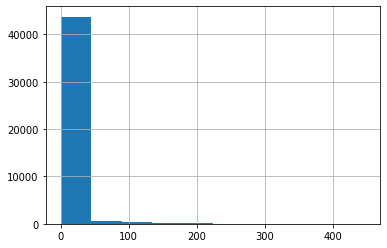

In [51]:
df_pf_final['min_target_diff'].hist()